In [105]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random

import re

## Text setup

In [106]:
with open("./data/ak.txt", "r", encoding="utf-8") as f: text = f.read().lower()

In [107]:
text = re.sub(r'[^\w\s\.\!\?]', '', text)
text = re.sub(r'[\!\?\.+]', '.', text)
text = re.sub(r'\s+', ' ', text)
text = re.sub(r'[\d_]', '', text)

int_to_char = sorted(list(set(text)))
char_to_int = dict((c, i) for i, c in enumerate(int_to_char))
vocab_size = len(int_to_char)

print("Total Characters:", len(text))
print("Vocab size:", len(int_to_char))
print("Characters [", *char_to_int.keys(), ']')

Total Characters: 1635683
Vocab size: 62
Characters [   . a b c d e f g h i j k l m n o p q r s t u v w x y z а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я ё ї ]


In [108]:
max_sntc_l = 100
min_sntc_l = 10

sentences = list(map(
    lambda x: x.strip() + '.',
    filter(lambda x: min_sntc_l <= len(x) <= max_sntc_l, text.split('.'))
    ))

print(len(sentences))
sentences[:10]

14846


['все смешалось в доме облонских.',
 'жена не выходила из своих комнат мужа третий день не было дома.',
 'да да как это было.',
 'думал он вспоминая сон.',
 'да как это было.',
 'алабин давал обед в дармштадте нет не в дармштадте а чтото американское.',
 'да но там дармштадт был в америке.',
 'глаза степана аркадьича весело заблестели и он задумался улыбаясь.',
 'да хорошо было очень хорошо.',
 'много еще чтото там было отличного да не скажешь словами и мыслями даже наяву не выразишь.']

## Markov chain

In [109]:
m_sntc = sentences
N = 5

In [110]:
def build_markov_chain(sntc):
    markov_chain = {}

    def add_to_chain(prefix, suffix):
        # print(f"\"{prefix}\" -> \"{suffix}\"")

        if prefix not in markov_chain:
            markov_chain[prefix] = {}

        if suffix not in markov_chain[prefix]:
            markov_chain[prefix][suffix] = 0

        markov_chain[prefix][suffix] += 1

    for s in sntc:
        for i in range(N):
            prefix = s[:i]
            suffix = s[i:i + 1]
            add_to_chain(prefix, suffix)

        for i in range(len(s) - N):
            prefix = s[i:i + N]
            suffix = s[i + N]
            add_to_chain(prefix, suffix)

    return markov_chain

In [111]:
def normalize_chain(markov_chain):
    normalized_chain = {}

    for prefix, suffixes in markov_chain.items():
        total = sum(suffixes.values())
        normalized_suffixes = {k: v/total for k, v in suffixes.items()}
        normalized_chain[prefix] = normalized_suffixes

    return normalized_chain

In [112]:
def complete_chain(norm_chain, prefix, max_length = 100):
    result = prefix
    prefix = result[-N:]
    cur_len = len(result)
    while cur_len < max_length:
        
        if prefix not in norm_chain:
            prefix = prefix[1:]
            continue      

        predicted_suffixes = norm_chain[prefix]
        next_suffix = random.choices(list(predicted_suffixes.keys()), list(predicted_suffixes.values()))[0]

        if next_suffix == '.':
            result += next_suffix
            return result

        result += next_suffix
        prefix = result[-N:]
        cur_len += 1

    return result + "..."


In [113]:
normalized_chain = normalize_chain(build_markov_chain(m_sntc))

In [114]:
prefix = "к"
predicted_suffixes = normalized_chain[prefix]
for ch, p in predicted_suffixes.items(): print(f"'{ch}' | {p * 100:.2f}%")

'а' | 50.67%
'р' | 7.10%
'у' | 4.56%
'т' | 3.49%
'о' | 16.09%
'и' | 10.32%
'н' | 5.09%
' ' | 2.14%
'в' | 0.13%
'е' | 0.13%
'с' | 0.13%
'л' | 0.13%


In [115]:
print(complete_chain(normalized_chain, ""))
print(complete_chain(normalized_chain, ""))

сказал вронский.
яшвин двух уток.


In [116]:
print(complete_chain(normalized_chain, "i"))
print(complete_chain(normalized_chain, "я"))

ix уже не ушел к кити не хочет разобразуется нельзя.
я уяснения из определать надо знакомы.


In [117]:
print(complete_chain(normalized_chain, "ch"))
print(complete_chain(normalized_chain, "в "))

charmante.
в соседней остановил лошадь слова.


In [118]:
print(complete_chain(normalized_chain, "the"))
print(complete_chain(normalized_chain, "что"))

the zest is gone.
что кажет.


In [119]:
print(complete_chain(normalized_chain, "vous "))
print(complete_chain(normalized_chain, "надолго ли"))
print(complete_chain(normalized_chain, "уже давно"))

vous mexcuserez mais il ne faut jamais il ne faut.
надолго лицо.
уже давно какая должен был как анне бывает ли он сказал как этом на из это сделаю это пожертвовать.


## LSTM

In [120]:
def string_tensor(string):
    tensor = torch.zeros([len(string), vocab_size])
    for i, ch in enumerate(string): tensor[i][char_to_int[ch]] = 1.
    tensor.requires_grad = True
    return tensor

def char_tensor(ch):
    tensor = torch.zeros(vocab_size)
    tensor[char_to_int[ch]] = 1.
    tensor.requires_grad = True
    return tensor

In [121]:
inputs_by_length = [[] for _ in range(max_sntc_l + 1)]
labels_by_length = [[] for _ in range(max_sntc_l + 1)]

for s in sentences[:2000]:
    for i in range(1, len(s), 1):
        inputs_by_length[i].append(string_tensor(s[:i]))
        labels_by_length[i].append(char_tensor(s[i]))
        # print(f"\"{s[:i]}\" -> \"{s[i]}\"")

print(sum([len(labels) for labels in labels_by_length]))

85075


In [122]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(vocab_size, 512, 1, batch_first=True)
        self.fc = nn.Linear(512, vocab_size)

    def forward(self, x):
        a, (b, c) = self.lstm(x)
        out = self.fc(c[-1, :])
        return out

In [123]:
model = Model()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [124]:
import numpy as np


batch_size = 1000

model.train()
train_loss = []

for epoch in range(20):
    losses = []
    for sntc_len in range(1, max_sntc_l + 1):
        inputs = inputs_by_length[sntc_len]
        labels = labels_by_length[sntc_len]

        # print(f"Inputs of length {sntc_len} -> {len(inputs)}")
        for i in range(0, len(inputs), batch_size):

            batch_inputs = torch.stack(inputs[i:i + batch_size])
            batch_labels = torch.stack(labels[i:i + batch_size])
            batch_inputs.requires_grad_()
            batch_labels.requires_grad_()

            # print(f"batch_inputs size {batch_inputs.size()}")
            # print(f"batch_labels size {batch_labels.size()}")
            

            optimizer.zero_grad()
            output = model(batch_inputs)
            # print(f"output size {output.size()}")

            l = loss(output, batch_labels)
            losses.append(l.item())
            l.backward()
            optimizer.step()
    train_loss.append(np.mean(losses))
    print(f"Epoch {epoch + 1} | Loss {train_loss[-1]:.4f}")

Epoch 1 | Loss 2.9406
Epoch 2 | Loss 2.5406
Epoch 3 | Loss 2.4116
Epoch 4 | Loss 2.2946
Epoch 5 | Loss 2.2012
Epoch 6 | Loss 2.1150
Epoch 7 | Loss 2.0415
Epoch 8 | Loss 1.9388
Epoch 9 | Loss 1.8402
Epoch 10 | Loss 1.7460
Epoch 11 | Loss 1.6574
Epoch 12 | Loss 1.6265
Epoch 13 | Loss 1.5372
Epoch 14 | Loss 1.4352
Epoch 15 | Loss 1.3346
Epoch 16 | Loss 1.2446
Epoch 17 | Loss 1.1646
Epoch 18 | Loss 1.1194
Epoch 19 | Loss 1.0429
Epoch 20 | Loss 0.9572


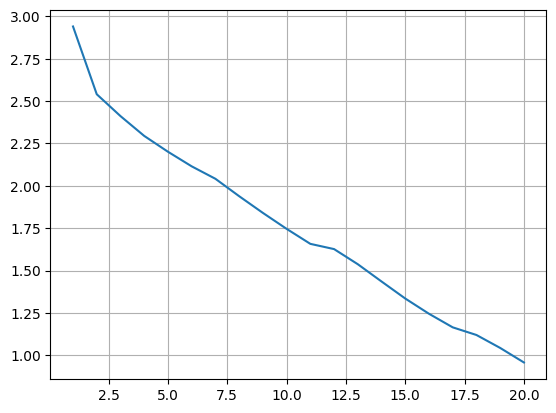

In [125]:
from matplotlib import pyplot as plt


plt.plot(range(1, len(train_loss) + 1), train_loss)
plt.grid(True)
plt.show()

In [128]:
model.eval()

def complete(prefix, max_length=100):
    with torch.no_grad():
        input_data = string_tensor(prefix).unsqueeze(0)
        output_str = prefix

        for _ in range(max_length):
            output = model(input_data)
            _, topi = output.topk(1)
            predicted_char = int_to_char[topi.item()]
            output_str += predicted_char
            if predicted_char == '.': break
            input_data = string_tensor(output_str[-max_sntc_l:]).unsqueeze(0)
            
        return output_str
        

print(complete("как"))
print(complete("чт"))
print(complete("я "))

как бы ты не повлечий людей.
что ж делать что это душа то что он демать.
я не забудт с ней.
